In [2]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional).to(device)
        self.fc = nn.Linear(self.num_directions * hidden_size, num_classes).to(device)

    # def forward(self, x):
    #     h_0 = Variable(torch.zeros(self.num_directions *
    #                                self.num_layers, x.size(0), self.hidden_size))
    #     c_0 = Variable(torch.zeros(self.num_directions *
    #                                self.num_layers, x.size(0), self.hidden_size))
    #     # Propagate input through LSTM
    #     ula, (h_out, _) = self.lstm(x, (h_0.to(device), c_0.to(device)))
    #     pred = self.fc(ula)
    #     pred = pred[:, -1, :]
    #     # h_out = h_out.view(-1, self.hidden_size)
    #     # out = self.fc(h_out)
    #     return pred
    def forward(self, input):
        w_ih = self.lstm.weight_ih_l0
        w_hh = self.lstm.weight_hh_l0
        b_ih = self.lstm.bias_ih_l0
        b_hh = self.lstm.bias_hh_l0
        w_hr = None
        h0 = Variable(torch.zeros(input.size(1), self.hidden_size).to(device))
        c0 = Variable(torch.zeros(input.size(1), self.hidden_size).to(device))
        # h0, c0 = initial_states # 初始状态
        # bs, T, i_size = input.shape
        T, bs, i_size = input.shape
        h_size = w_ih.shape[0]  # 20
        h_size = h_size // 4  # 分为4份

        prev_h = h0  # 不停更新h0 c0
        prev_c = c0
        batch_w_ih = w_ih.unsqueeze(0).tile(bs, 1, 1)  # bs * 4*h_size * i_size
        batch_w_hh = w_hh.unsqueeze(0).tile(bs, 1, 1)  # bs * 4*h_size * h_size

        if w_hr is not None:
            p_size, _ = w_hr.shape
            output_size = p_size
            batch_w_hr = w_hr.unsqueeze(0).tile(bs, 1, 1)
        else:
            output_size = h_size
        output = torch.zeros(bs, T, output_size)  # 输出序列
        print(T)
        for t in range(T):
            print(f"T:{t}")
            x = input[t, :, :]  # 当前时刻的输入向量 bs * i_size
            w_times_x = torch.bmm(batch_w_ih, x.unsqueeze(-1))  # bs * 4*h_size * 1
            w_times_x = w_times_x.squeeze(-1)  # bs * 4*h_size

            w_times_h = torch.bmm(batch_w_hh, prev_h.unsqueeze(-1))  # bs * 4*h_size * 1
            w_times_h = w_times_h.squeeze(-1)  # bs * 4*h_size

            # 分别各取四分之一
            i_t = torch.sigmoid(w_times_x[:, :h_size] + w_times_h[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])  # 取前四分之一
            f_t = torch.sigmoid(
                w_times_x[:, h_size: 2 * h_size] + w_times_h[:, h_size: 2 * h_size] + b_ih[h_size: 2 * h_size] + b_hh[
                                                                                                                 h_size: 2 * h_size])
            g_t = torch.tanh(w_times_x[:, 2 * h_size: 3 * h_size] + w_times_h[:, 2 * h_size: 3 * h_size] + b_ih[
                                                                                                           2 * h_size: 3 * h_size] + b_hh[
                                                                                                                                     2 * h_size: 3 * h_size])
            o_t = torch.sigmoid(
                w_times_x[:, 3 * h_size:] + w_times_h[:, 3 * h_size:] + b_ih[3 * h_size:] + b_hh[3 * h_size:])
            prev_c = f_t * prev_c + i_t * g_t
            prev_h = o_t * torch.tanh(prev_c)

            if w_hr is not None:  # 进行projection 对维度进行压缩
                prev_h = torch.bmm(batch_w_hr, prev_h.unsqueeze(-1))
                prev_h = prev_h.squeeze(-1)

            output[:, t, :] = prev_h
        print("DONE!")
        return prev_h

file = '330102'


def load_data():
    rawdata = pd.read_csv(f'data/groupByCZ/{file}MYL.csv')
    rawdata.columns = ['', 'RCD', 'TM', 'INTV', 'DRP', 'MODITIME', 'SOURCE']
    rawdata = rawdata.drop(columns='RCD')
    # rawdata = rawdata.drop(columns='TM')
    rawdata = rawdata.loc[:, ~rawdata.columns.str.contains('^Unnamed')]
    rawdata.fillna(rawdata.mean(), inplace=True)
    rawdata.DRP = rawdata.DRP.astype("float32")
    return rawdata


def strlist_to_date(s):
    def is_run(yyyy):
        if yyyy % 400 == 0:
            return 1
        if yyyy % 4 == 0 and yyyy % 100 != 0:
            return 1
        return 0

    res = []
    for i in s:
        yyyy = int(i[:4])
        mm = int(i[5:7])
        dd = int(i[8:10])
        month = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
        day = month[mm - 1] + dd + (is_run(yyyy) if mm >= 2 else 0)
        res.append(day)
    return res

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [1]:
import math
import time
from itertools import chain

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from keras.losses import MSE
from numpy import concatenate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


(24829, 7, 2) (24829, 2)
torch.Size([19863, 7, 2])
torch.Size([19863, 2])


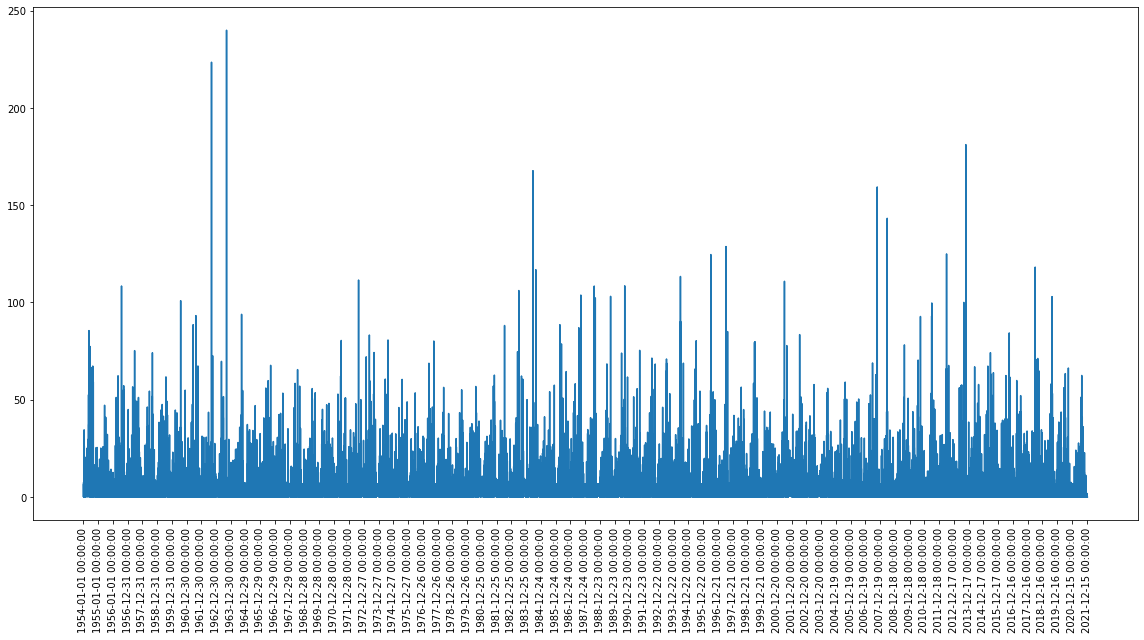

In [3]:
# def process_data():
dataset = load_data()
# print(dataset)
plt.figure(figsize=(16, 9))
plt.plot(dataset['DRP'])
plt.xticks(range(0, dataset.shape[0], 365), dataset['TM'].loc[::365], rotation=90)
plt.tight_layout()
plt.savefig(f'data/img/{file}MYL.jpg')
dataset = dataset.drop(columns='TM')
dataset = dataset.drop(columns='INTV')
dataset = dataset.drop(columns='MODITIME')
dataset = dataset.drop(columns='SOURCE')

# dataset.TM = strlist_to_date(dataset.TM.values)
# print(dataset)
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

seq_len = 7
x, y = sliding_windows(dataset, seq_len)

print(x.shape, y.shape)
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x))).to(device)
dataY = Variable(torch.Tensor(np.array(y)).cuda()).to(device)

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(device)
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(device)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).to(device)
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).to(device)
print(trainX.shape)
print(trainY.shape)

In [ ]:
input_size = 2
hidden_size = 7
num_layers = 1
output_size = 2
epochs = 1

model = LSTM(input_size, hidden_size, num_layers, output_size, False).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training
start = time.time()
train_loss = []
for epoch in range(epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    # print(outputs.shape)
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    # if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    train_loss.append(loss.item())
print('Time Used:', time.time() - start)

19863
T:0
T:1
T:2
T:3
T:4
T:5
T:6
T:7
T:8
T:9
T:10
T:11
T:12
T:13
T:14
T:15
T:16
T:17
T:18
T:19
T:20
T:21
T:22
T:23
T:24
T:25
T:26
T:27
T:28
T:29
T:30
T:31
T:32
T:33
T:34
T:35
T:36
T:37
T:38
T:39
T:40
T:41
T:42
T:43
T:44
T:45
T:46
T:47
T:48
T:49
T:50
T:51
T:52
T:53
T:54
T:55
T:56
T:57
T:58
T:59
T:60
T:61
T:62
T:63
T:64
T:65
T:66
T:67
T:68
T:69
T:70
T:71
T:72
T:73
T:74
T:75
T:76
T:77
T:78
T:79
T:80
T:81
T:82
T:83
T:84
T:85
T:86
T:87
T:88
T:89
T:90
T:91
T:92
T:93
T:94
T:95
T:96
T:97
T:98
T:99
T:100
T:101
T:102
T:103
T:104
T:105
T:106
T:107
T:108
T:109
T:110
T:111
T:112
T:113
T:114
T:115
T:116
T:117
T:118
T:119
T:120
T:121
T:122
T:123
T:124
T:125
T:126
T:127
T:128
T:129
T:130
T:131
T:132
T:133
T:134
T:135
T:136
T:137
T:138
T:139
T:140
T:141
T:142
T:143
T:144
T:145
T:146
T:147
T:148
T:149
T:150
T:151
T:152
T:153
T:154
T:155
T:156
T:157
T:158
T:159
T:160
T:161
T:162
T:163
T:164
T:165
T:166
T:167
T:168
T:169
T:170
T:171
T:172
T:173
T:174
T:175
T:176
T:177
T:178
T:179
T:180
T:181
T:182
T:183


In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(range(len(train_loss)), train_loss)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training Loss', fontsize=20)
plt.show()

In [ ]:
model.eval()
train_predict = model(testX)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = testY.cpu().data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)
# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10, 7))
plt.plot(dataY_plot[:, 1], )
plt.plot(data_predict[:, 1])
plt.title('Time-Series Prediction', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'data/img/{file}MYL_predict.jpg')

In [ ]:
data_predict_ = data_predict[:, 1]
dataY_plot_ = dataY_plot[:, 1]
mae = mean_absolute_error(dataY_plot_, data_predict_)
mse = mean_squared_error(dataY_plot_, data_predict_)
rmse = np.sqrt(mean_squared_error(dataY_plot_, data_predict_))
# mape = (abs(dataY_plot_ - data_predict_) / dataY_plot_).mean()
r_2 = r2_score(dataY_plot_, data_predict_)
mape = 0
for i in range(data_predict_.size):  #求Σ过程
    mae = mae + abs(dataY_plot_[i] - data_predict_[i])  #MAE差的绝对值
    if dataY_plot_[i] == 0:  #MAPE需要分情况处理
        # continue
        if data_predict_[i] != 0:
            mape = mape + 1
    else:
        mape = mape + abs((dataY_plot_[i] - data_predict_[i]) / dataY_plot_[i])
mape /= data_predict_.size

In [ ]:

score = list([mae, rmse, mape, r_2])
print(score)

In [ ]:
# 2000epochs:[3.7965586, 14.193142, inf, 0.5756781514159137]
# 10000epochs:[3.5685904, 12.825364, inf, 0.5918739562691975]
# 0.001lr, 10000epochs[2.5530255, 7.4692106, inf, 0.5955862657909915]
# LSTM训练浙江省总面雨量数据，使用的数据为浙江省从1954年至2021年每天的总面雨量，为每天一个数据，采用hidden_size = 16，batch_size = 28，epochs = 10000，learnrate = 0.001等参数进行训练，得到RMSE = 7.5829153，MAPE = 25.656005690943584的结果，还需要进一步优化

In [ ]:
[20967.73, 7.5829153, 25.656005690943584, 0.21088513416902355]